# **FRAUD DETECTION BENCHMARKING**


**IMPORTING DATA & LIBRARIES**

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')  # Mount google drive to store benchmarking results and logs

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import kagglehub
import os

os.environ['KAGGLEHUB_CACHE'] = os.getcwd() # Setting download directory to current folder

# Download latest version
path = kagglehub.dataset_download("amanalisiddiqui/fraud-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 178M/178M [00:02<00:00, 80.7MB/s]

Extracting files...


Path to dataset files: /content/datasets/amanalisiddiqui/fraud-detection-dataset/versions/1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

**READING THE DATASET, PARSING DATES, AND SETTING DATATYPES**

In [ ]:
dataset_path =  path + "/AIML Dataset.csv"

# Defining datatypes of each column to optimise memory
dtypes = {
            # Numerical columns
            'step': 'int16',
            'amount': 'float32',
            'oldbalanceOrg': 'float32',
            'newbalanceOrig': 'float32',
            'oldbalanceDest': 'float32',
            'newbalanceDest': 'float32',
            'isFraud': 'int8',
            'isFlaggedFraud': 'category',

            # Alphanumeric columns
            'type': 'category',
            'nameOrig': 'string',
            'nameDest': 'string',

        }


df = pd.read_csv(
                dataset_path,
                dtype = dtypes
                )

As per the above graph, on average, the highest number of fraud rate is observed in **TRANSFER** type transactions

### Finding the distribution of the 'amount' column

<Axes: xlabel='hour_of_day'>

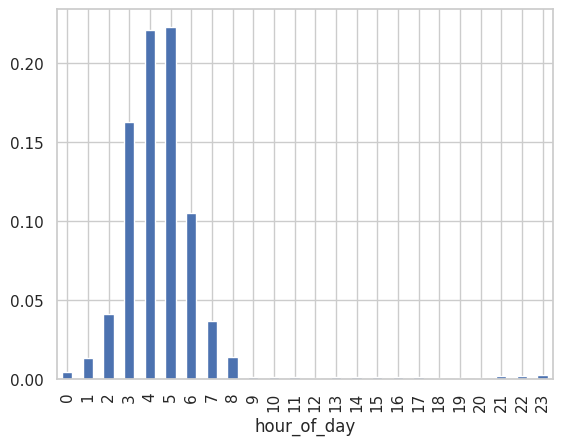

In [ ]:
df['hour_of_day'] = df['step'] % 24
df.astype({'isFraud':'int'}).groupby('hour_of_day')['isFraud'].mean().plot(kind='bar')

In [ ]:
# Adding additional features
df['day_of_month'] = df['step'] // 24 + 1

df['timestamp'] = pd.to_datetime('2020-01-01') + pd.to_timedelta(df['step'], unit='h')
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day_of_month,timestamp,day,hour,weekday,hour_of_day
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0,1,2020-01-01 01:00:00,1,1,2,1
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0,1,2020-01-01 01:00:00,1,1,2,1
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0,1,2020-01-01 01:00:00,1,1,2,1
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1,0,1,2020-01-01 01:00:00,1,1,2,1
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0,0,1,2020-01-01 01:00:00,1,1,2,1


## Step 0: Feature selection
1. Drop any columns that are not needed
1. Create lists of features that are numeric and categorical
1. Set appropriate datatytpes for features
1. Create any new features
1. Split dataset into target variable vector *y* and feature matrix *X*

1. Drop any columns that are not needed

In [ ]:
columns_to_remove = [
                      "step", #As discussed earlier, the transactions don't seem to have a realistic relationship with time, owing to the data being synthetic
                      "timestamp",#Same reason as above
                      "weekday", #Same reason as above
                      "day_of_month", #Same reason as above
                      "day", #Same reason as above
                      "hour", #Same reason as above
                      "nameOrig", #In this dataset, most of the transactions are done by unique account. Therefore, it does not reveal any further information about the transaction being fraud
                      "nameDest", #Same reason as above
                      "isFlaggedFraud" #This is not required for modelling purposes
                      ]

df_clean = df.drop(columns=columns_to_remove)

2. Create lists of features that are numeric and categorical


In [ ]:
numerical = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
categorical = ["type", "hour_of_day"]

3. Set appropriate datatytpes for features

Data types were set during the import of the dataset

4. Create any new features


The only feature added to the model was 'hour_of_day'

5. Split dataset into target variable vector *y* and feature matrix *X*

In [ ]:
y, X = df_clean["isFraud"], df_clean.drop(columns="isFraud")

# BENCHMARKING BEGINS

### Importing all required libraries

In [ ]:
# Importing libraries relevant to transformations, pipelining, cross-validation, and evaluation

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Classical classifiers

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Gradient boosting classifiers

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
# Additional libraries

import time # for timing model fitting
import joblib # for saving the final model
import os # For stringing together directories to be used for saving
from pathlib import Path # For creating directories
import json # For saving metadata as a json file
from datetime import datetime, timedelta # For correcting timestamps from UTC to India Standard Time

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state = 99, sampling_strategy = 'minority')

In [ ]:
X_resampled, y_resampled = sm.fit(X, y)

TypeError: cannot unpack non-iterable SMOTE object

### Defining important functions for the model benchmarking

1. **get_preprocessor:** for creating the preprocessor objects (imputer and scaler for numerical columns; imputer and one-hot-encoder for categorical columns)

1. **build_model_constructors:** for creating the model objects for each classifier

1. **build_pipeline:** for creating pipelines for each model. Each model pipeline is simply its preprocessor followed by the model constructor

1. **benchmark_models:** run the pipelines for each model using cross validation and collect important metrics to rank the models and select the best one

In [ ]:
# defining preprocessor function

def get_preprocessor(num_cols, cat_cols, scaler: bool = False, impute_strategy = "median"):
    """
        Returns a ColumnTransformer where numeric features are imputed using the median
        and scaled optionally, and categorical features are imputed (most_frequent)
        then OneHotEncoded.
    """

    # Creating transformation steps for numerical columns

    numerical_transformation = [
                ("imputer", SimpleImputer(strategy=impute_strategy))
    ]

    if scaler:

        numerical_transformation.append(
                ("scaler", StandardScaler())
        )

    numerical_pipeline = Pipeline(numerical_transformation)


    # Creating transformation steps for categorical columns

    categorical_transformation = [
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore", drop = 'first', sparse_output=False))
    ]

    categorical_pipeline = Pipeline(categorical_transformation)


    # Defining the preprocessor

    preprocessor = ColumnTransformer([
            ("num", numerical_pipeline, num_cols),
            ("cat", categorical_pipeline, cat_cols)
    ],       remainder = 'drop', sparse_threshold=0)

    return preprocessor

In [ ]:
for scaler in [True, False]:
    if scaler:
        print('Column Transformer for models requiring scaling:')
    else:
        print('Column Transformer for not requiring scaling:')
    display(get_preprocessor(numerical, categorical, scaler = scaler))
    print('\n')

Column Transformer for models requiring scaling:


ColumnTransformer(sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['amount', 'oldbalanceOrg', 'newbalanceOrig',
                                  'oldbalanceDest', 'newbalanceDest']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['type', 'hour_of_day'])])



Column Transformer for not requiring scaling:


ColumnTransformer(sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['amount', 'oldbalanceOrg', 'newbalanceOrig',
                                  'oldbalanceDest', 'newbalanceDest']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['type', 'hour_of_day'])])

In [ ]:
# Building model constructors

def build_model_constructors(y):

    pos = int(np.sum(y == 1))
    neg = int(np.sum(y == 0))

    scale_pos_weight = (neg / pos) if pos > 0 else 1.0

    constructors = {

        "LogisticRegression": lambda: LogisticRegression(
                                        class_weight = "balanced",
                                        max_iter = 1000,
                                        random_state = 99,
                                        solver = "sag", # Using SAG solver because of large n,
                                                       # low p, and dense input data
                                        n_jobs = -1
        ),

        "SVC": lambda: SVC(
                        probability = True,
                        class_weight = 'balanced',
                        kernel = 'rbf',
                        random_state = 99
        ),

        "GaussianNB": lambda: GaussianNB(),

        "KNN": lambda: KNeighborsClassifier(
                        n_neighbors = 5,
                        algorithm = 'kd_tree',   # 'ball_tree' or 'kd_tree' are good for low-dim
                        leaf_size = 40,
                        n_jobs = -1
        ),

        "DecisionTree": lambda: DecisionTreeClassifier(
                        class_weight = 'balanced',
                        max_depth = 8,
                        min_samples_leaf = 100,
                        random_state = 99
        ),

        "XGBoost": lambda: XGBClassifier(
                        n_estimators=300,
                        eval_metric="logloss",
                        tree_method="hist",
                        scale_pos_weight=scale_pos_weight,
                        learning_rate=0.05,
                        max_depth=5,
                        subsample=0.8,
                        random_state=99,
                        n_jobs=-1
        ),

        "LightGBM": lambda: LGBMClassifier(
                        n_estimators = 300,
                        boosting_type = "gbdt",
                        class_weight = "balanced",
                        learning_rate = 0.05,
                        max_depth = 9,
                        num_leaves = 50,
                        subsample = 0.8,
                        n_jobs = -1,
                        random_state = 99
        ),

        "RandomForest": lambda: RandomForestClassifier(
                        n_estimators = 100
        )


    }

    return constructors


In [ ]:
# Building pipelines

def build_pipelines(num_cols, cat_cols, y):
    """
    Build pipelines mapping model name -> Pipeline(preprocessor + estimator).


    Parameters
    ----------
    num_cols, cat_cols : list[str]
    Column lists for numeric and categorical features. Assumes get_preprocessor
    is defined elsewhere (same as your earlier code).
    y_train : array-like
    Used to create model constructors (for scale_pos_weight & heuristics).
    n_rows : int or None
    Dataset row count. If large, pipelines for very heavy models are prepared
    but flagged so the benchmark function can skip them by default.
    """

    constructors = build_model_constructors(y)

    preprocessor_scaled = get_preprocessor(num_cols, cat_cols, scaler = True)
    preprocessor_unscaled = get_preprocessor(num_cols, cat_cols, scaler = False)

    need_scaling = {
                    "LogisticRegression", # These models need standard scaling
                    "SVC",
                    "KNN",
                    "GaussianNB"
                    }

    pipelines = {} # Initialising an empty dictionary to store pipeline metadata pertaining to each model

    for name, constructor in constructors.items():
        preprocessor = preprocessor_scaled if name in need_scaling else preprocessor_unscaled
        pipeline = Pipeline([
                            ("preprocessor", preprocessor),
                            ("clf", constructor())
        ])

        # pipeline._meta = metadata.get(constructor, {})
        pipelines[name] = pipeline

    return pipelines

In [ ]:
def get_ist_ts(time_only = False, proper_date = False):
  """
  Helper function to return the current timestamp according to India Standard Time
  instead of Universal Coordinated Time (Google Colab default)
  """
  utc_time = datetime.now() # Obtaining the current time (UTC)
  ist_time = utc_time + timedelta(hours = 5.5) # Shifting time ahead by 5.5 hours to get India time

  if time_only:
    time_format = '%I:%M %p' # Getting time in the format '10:30 AM'
  elif proper_date:
    time_format = '%d %b %Y %H:%M:%S'
  else:
    time_format = '%Y%m%d_%H%M%S' # Getting date and time in the format '20260109_103005' for 10:30:05 AM on 9 Jan 2026

  ist_ts = ist_time.strftime(time_format) # Converting IST time to timestamp

  return ist_ts

In [ ]:
# Defining function for saving scores to Google drive

def save_scores(scores, model_name, exe_dir, exe_n, model_start_ts):
  """
  Save the raw scores dict (as returned by cross_validate) using joblib.
  Also write a small JSON metadata file and append a single-line summary to CSV.
  """
  model_end_ts = get_ist_ts(time_only = True) # Obtain the current timestamp for model fitting

  model_dir = exe_dir + model_name # Specify path for storing current model stats

  Path(model_dir).mkdir(parents=True, exist_ok=True) # Calling Path.mkdir() to create the folder

  base = f"{model_name.replace(' ', '_')}_{model_start_ts}" # specifying the model name

  # Specify paths for joblib, metadata, and csv files
  joblib_path = os.path.join(model_dir, base + ".joblib")
  meta_path = os.path.join(model_dir, base + "_meta.json")
  csv_summary = os.path.join(model_dir, "benchmark_summary.csv")

  # Save raw dict with joblib (keeps numpy arrays)
  joblib.dump(scores, joblib_path, compress=('gzip', 3))

  # create a small human-readable meta summary
  meta = {}

  for k, v in scores.items():
    try:
      meta[k] = {
      "type": type(v).__name__,
      "length": v.shape[0],
      "sample": None if not hasattr(v, "__len__") else (v[:5].tolist() if hasattr(v, "tolist") else str(v)[:200])
                }
    except Exception:
      meta[k] = str(type(v))

  with open(meta_path, "w") as f:
    json.dump({
              "model": model_name,
              "execution_number": exe_n,
              "model_fit_started": model_start_ts,
              "model_fit_ended": model_end_ts,
              "meta": meta
              },

              f, indent=2)

  # Append row to CSV summary (safe create if missing)
  row = {
      "timestamp": model_end_ts,
      "model": model_name,
      # compute simple aggregated metrics if present
      "pr_auc_mean": float(np.nanmean(scores.get("test_pr_auc"))) if scores.get("test_pr_auc") is not None else None,
      "pr_auc_std": float(np.nanstd(scores.get("test_pr_auc"))) if scores.get("test_pr_auc") is not None else None,
      "roc_auc_mean": float(np.nanmean(scores.get("test_roc_auc"))) if scores.get("test_roc_auc") is not None else None,
      "roc_auc_std": float(np.nanstd(scores.get("test_roc_auc"))) if scores.get("test_roc_auc") is not None else None,
      "recall_mean": float(np.nanmean(scores.get("test_recall"))) if scores.get("test_recall") is not None else None,
      "recall_std": float(np.nanstd(scores.get("test_recall"))) if scores.get("test_recall") is not None else None,
      "precision_mean": float(np.nanmean(scores.get("test_precision"))) if scores.get("test_precision") is not None else None,
      "precision_std": float(np.nanstd(scores.get("test_precision"))) if scores.get("test_precision") is not None else None,
      "fit_time_total_min": float(np.nansum(scores.get("fit_time", np.array([0.0])))) / 60,
      "score_time_total_min": float(np.nansum(scores.get("score_time", np.array([0.0])))) / 60
  }

  row['total_time_min'] = row['fit_time_total_min'] + row['score_time_total_min']

  df_row = pd.DataFrame([row])
  if not os.path.exists(csv_summary):
    df_row.to_csv(csv_summary, index=False)
  else:
    df_row.to_csv(csv_summary, mode="a", header=False, index=False)

  return {"joblib": joblib_path, "meta": meta_path, "csv": csv_summary}, row

In [ ]:
def get_execution_details(main_directory, n_rows, bm_proportion, n_splits):
  """
  Helper function for creating/appending to the execution log file:

    1. The execution number
    2. the timestamp

  Additionally, it also returns the execution number and timestamp to be used in the metadata
  """

  log_file_dir = main_directory + 'execution_log.csv'

  with open(log_file_dir, 'a+') as f:
    f.seek(0)
    content = f.readlines()

    execution_ts = get_ist_ts(proper_date = True)

    execution_ts_return = get_ist_ts()

    header_cols = [
                    'execution number',
                    'date and time started',
                    'n (folds)',
                    'n (rows)',
                    'benchmark proportion'
                ]

    header = ','.join(header_cols)

    if len(content) == 0:
      current_execution_n = '1'
      f.write(header)
      f.write('\n')

    else:
      last_execution_n = int(content[-1].split(',')[0])
      current_execution_n = str(int(last_execution_n) + 1)
      f.seek(0,2) # Setting the file pointer at the end of the file for appending
      f.write('\n') # Adding a new line

    current_execution_data = [
                              current_execution_n,
                              execution_ts,
                              str(n_splits),
                              str(n_rows),
                              f'{bm_proportion*100:.2f}%'
                            ]


    current_execution = ','.join(current_execution_data) # Creating the data to be written in the current row
    f.write(current_execution) # Writing the data to file

  return int(current_execution_n), execution_ts_return # Returning the current execution number to be used in the metadata

In [ ]:
def save_confusion_matrix(cm, model_name, model_dir):
  """
  Helper function for generating confusion matrices
  """

  cm_df = pd.DataFrame(cm)
  cm_df.columns = ['Predicted Neg', 'Predicted Pos']
  cm_df.index = ['Actual Neg', 'Actual Pos']

  cm_path = os.path.join(model_dir, model_name, 'confusion_matrix.csv')

  cm_df.to_csv(cm_path, header = True, index = True)

  sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd')
  plt.xlabel('Predicted Values')
  plt.ylabel('Actual Values')
  plt.title(model_name)

  cm_plot_path = os.path.join(model_dir, model_name, 'confusion_matrix_plot.png')

  plt.savefig(cm_plot_path)

  print(f'\nConfusion matrix csv and plot saved succesfullt to: {model_dir}')

In [ ]:
def benchmark_models(pipelines, X_b, y_b, X_v, y_v, X_t, y_t, bm_proportion, val_proportion, n_splits=3, random_state = 99):
  """
  Run cross-validated benchmarking for each pipeline and collect metrics.
  Returns a DataFrame sorted by PR-AUC then recall.
  """

  ## SPECIFYING THE STRATIFIED K-FOLD OBJECT AND SCORING METRICS FOR CROSS-VALIDATION

  n_rows = X.shape[0]

  skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = random_state)

  scoring = {
              "precision": make_scorer(precision_score, pos_label = 1),
              "recall": make_scorer(recall_score, pos_label = 1),
              "roc_auc": "roc_auc",
              "pr_auc": "average_precision"
          }


  print('*'*100,'STARING EXECUTION!','*'*100,'\n\n')



  ## CREATING AND SETTING DIRECTORIES FOR STORING RESULTS

  main_gdrive = '/content/drive/MyDrive/fraud_detection_benchmarking/' # Specify Google Drive folder where current execution results will be stored

  Path(main_gdrive).mkdir(parents = True, exist_ok = True) # Creating the directory if it already doesn't exist

  exe_n, exe_ts = get_execution_details(main_gdrive, n_rows, bm_proportion, n_splits) # Storing the current execution details in the log file and obtaining the execution number and timestamp

  current_exe_dir = main_gdrive + f'exe_{str(exe_n)}_{exe_ts}/' # Creating filepath for current execution directory

  print(f'Creating a new folder at {current_exe_dir}\n\n')
  Path(current_exe_dir).mkdir(parents = True, exist_ok = True) # Creating the current exeuction directory

  print('Saving validation & test files to the execution folder...\n\n')

  X_v.to_csv(os.path.join(current_exe_dir, 'X_validation.csv'), header = True, index = False)
  y_v.to_csv(os.path.join(current_exe_dir, 'y_validation.csv'), header = True, index = False)
  X_t.to_csv(os.path.join(current_exe_dir, 'X_test.csv'), header = True, index = False)
  y_t.to_csv(os.path.join(current_exe_dir, 'y_test.csv'), header = True, index = False)

  print('Files saved.\n\n')



  ## BEGIN BENCHMARKING

  print('BENCHMARKING BEGINS!')

  rows = []

  for name, pipeline in pipelines.items():
    # meta = getattr(pipline, "_meta", {})

    print(f"\n\nCross-validation running for {name}...")

    start = time.time()

    model_start_ts = get_ist_ts(time_only = True)

    outputs = []

    try:
        scores = cross_validate(
            pipeline, X_b, y_b,
            cv = skf, scoring = scoring,
            return_train_score = False,
            # n_jobs = -1,
            error_score = 'raise',
            return_estimator = True
        )

        print('Model run succesfully!')

        # Saving results to drive:
        out, model_stats = save_scores(scores, model_name = name, exe_dir = current_exe_dir, exe_n = exe_n, model_start_ts = model_start_ts) # Obtaining filepaths and model stats
        rows.append(model_stats) # Appending list of model stats dictionaries
        print("Results saved to Drive:\n", out)

        # Creating predictions for creating and saving confusion matrix

        print('\nCreating confusion matrix...')

        model = scores['estimator'][0]
        y_pred = model.predict(X_v)
        cm = confusion_matrix(y_v, y_pred)

        save_confusion_matrix(cm, name, current_exe_dir)
        plt.close()

    except Exception as e:
        print(f"\nError running {name}: {e}")

        failed_model = {
                        "timestamp": get_ist_ts(time_only = True),
                        "model": name + ' (failed)'
                        }

        rows.append(failed_model)


    finally:
        end = time.time()
        time_taken = end - start
        print(f'\nTime taken for {name}: {time_taken/60:.2f} minutes.')



  ## STORING MODEL RESULTS IN SINGLE CSV TO BE COMPARED

  print('\n'*3,'*'*100,'ALL MODELS DONE','*'*100)

  results = pd.DataFrame(rows).fillna('-')
  results_path = current_exe_dir + 'results.csv'
  results.to_csv(results_path, header = True, index = False)

  return outputs

In [ ]:
# Set proportion of data for benchmarking and validation

bm_proportion = 0.15
X_benchmark, X_validation_test, y_benchmark, y_validation_test = train_test_split(X, y, test_size = 1 - bm_proportion, stratify = y, random_state = 99)

print(f'{bm_proportion*100:.2f}% of the data being used for training & benchmarking!\n')


val_proportion = 0.5
X_validation, X_test, y_validation, y_test = train_test_split(X_validation_test, y_validation_test, test_size = 1 - val_proportion, random_state = 99)

print(f'{val_proportion*(1-bm_proportion)*100:.2f}% of the data being used for validation!\n')
print(f'{(1-val_proportion)*(1-bm_proportion)*100:.2f}% of the data being used for testing!')

15.00% of the data being used for training & benchmarking!

42.50% of the data being used for validation!

42.50% of the data being used for testing!


In [ ]:
pipelines = build_pipelines(numerical, categorical, y)

In [ ]:
def remove_models(models: set, pipelines: dict) -> dict:
  """
  Helper function to remove specified models for executions
  """
  models_to_keep = pipelines.keys() - models
  pipelines = {model: pipelines[model] for model in models_to_keep}
  return pipelines

In [ ]:
models_to_remove = {
                    # 'LogisticRegression'
                    'SVC'
                    # ,'KNN'
                    # ,'nextModel'
}

pipelines = remove_models(models_to_remove, pipelines)

In [ ]:
benchmark_models(
                  pipelines = pipelines,
                  X_b = X_benchmark,
                  y_b = y_benchmark,
                  X_v = X_validation,
                  y_v = y_validation,
                  X_t = X_test,
                  y_t = y_test,
                  bm_proportion = bm_proportion,
                  val_proportion = val_proportion,
                  n_splits=5
                )

**************************************************************************************************** STARING EXECUTION! **************************************************************************************************** 


Creating a new folder at /content/drive/MyDrive/fraud_detection_benchmarking/exe_6_20260118_173124/


Saving validation & test files to the execution folder...


Files saved.


BENCHMARKING BEGINS!


Cross-validation running for LightGBM...
[LightGBM] [Info] Number of positive: 986, number of negative: 762528
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1329
[LightGBM] [Info] Number of data points in the train set: 763514, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 985, 